### Fitting the Model to the Scotland Lip Cancer Dataset

In [1]:
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import json

In [2]:
if not cmdstanpy.cmdstan_path():
    cmdstanpy.install_cmdstan()

with open("data/scotland_data.json") as file:
    scotland_data = json.load(file)

def mungeCARdata4stan(adjBUGS, numBUGS):
    N = len(numBUGS)
    nn = numBUGS
    N_edges = len(adjBUGS) // 2
    node1 = np.zeros(N_edges, dtype=int)
    node2 = np.zeros(N_edges, dtype=int)
    iAdj = 0
    iEdge = 0
    
    for i in range(N):
        for j in range(nn[i]):
            iAdj += 1
            if i + 1 < adjBUGS[iAdj - 1]:
                iEdge += 1
                node1[iEdge - 1] = i + 1
                node2[iEdge - 1] = adjBUGS[iAdj - 1]
    
    return {
        "N": N,
        "N_edges": N_edges,
        "node1": node1,
        "node2": node2
    }

In [3]:
nbs = mungeCARdata4stan(
    scotland_data["adj"], scotland_data["num"]
)

scotland_data_subset = {
    "y": scotland_data["y"],
    "x": scotland_data["x"],
    "E": scotland_data["E"]
}

data = {**nbs, **scotland_data_subset}
bym_model = CmdStanModel(stan_file="stan/bym_predictor_plus_offset.stan")
bym_scot_stanfit = bym_model.sample(data=data, show_progress=True)

13:50:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:50:36 - cmdstanpy - INFO - CmdStan done processing.
13:50:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'bym_predictor_plus_offset.stan', line 42, column 2 to column 34)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bym_predictor_plus_offset.stan', line 42, column 2 to column 34)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bym_predictor_plus_offset.stan', line 42, column 2 to column 34)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bym_predictor_plus_offset.stan', line 42, column 2 to column 34)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bym_predictor_plus_offset.stan', line 42, column 2 to column 34)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bym_predictor_plus_offset.stan', line 42, column 2 to column 34)
E

In [4]:
vars = [
    "lp__",
    "beta0",
    "beta1",
    "sigma_phi",
    "tau_phi",
    "sigma_theta",
    "tau_theta",
    "mu[5]",
    "phi[5]",
    "theta[5]",
]
bym_scot_stanfit.summary().loc[vars]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,756.369000,0.265878,8.843600,741.202000,756.633000,770.546000,1106.35000,54.97950,1.003400
beta0,-0.288917,0.004252,0.169606,-0.572401,-0.284515,-0.012668,1591.18000,79.07260,1.000700
beta1,0.042256,0.000433,0.016910,0.014046,0.042364,0.069153,1525.31000,75.79940,1.000660
sigma_phi,0.665590,0.003770,0.134780,0.470670,0.649290,0.906930,1276.15177,63.41757,1.000700
tau_phi,2.539730,0.027907,1.029370,1.212560,2.372490,4.512970,1360.53000,67.61070,1.001070
sigma_theta,0.481890,0.001380,0.069170,0.381540,0.474140,0.607850,2498.60043,124.16640,1.000740
tau_theta,4.568210,0.024448,1.277840,2.705760,4.448400,6.858350,2731.99000,135.76500,1.000960
mu[5],14.079800,0.049036,3.328250,9.053250,13.848700,19.978800,4606.89000,228.93700,0.999731
phi[5],1.262150,0.011078,0.474932,0.511896,1.237210,2.072990,1838.07000,91.34160,1.000510
theta[5],0.413272,0.011479,0.697002,-0.757374,0.431703,1.529180,3686.90000,183.21800,1.000050


## Bigger data: from 56 counties in Scotland to 1921 census tracts in New York City

/Users/farhanreynaldo/Documents/Open Sources/example-models/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


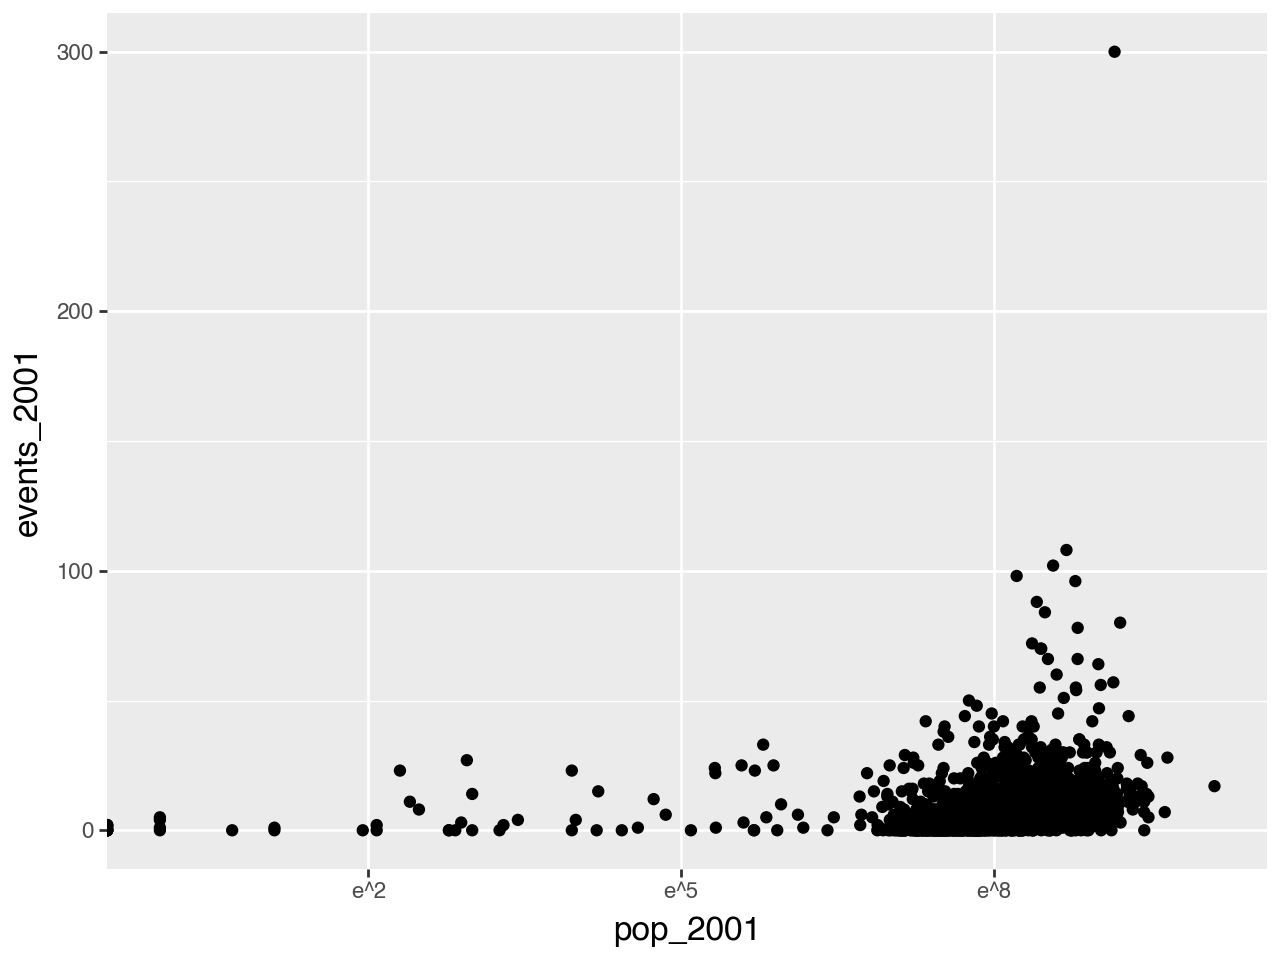

In [5]:
import pandas as pd
import plotnine as p9

p9.theme_set(
    p9.theme_grey()
    + p9.theme(
        text=p9.element_text(size=10),
        plot_title=p9.element_text(size=14),
        axis_title_x=p9.element_text(size=12),
        axis_title_y=p9.element_text(size=12),
        axis_text_x=p9.element_text(size=8),
        axis_text_y=p9.element_text(size=8),
    )
)

nyc_subset = pd.read_json("data/nyc_subset.json", dtype={"nyc_tractIDs": str})

(
    p9.ggplot(data=nyc_subset, mapping=p9.aes(x="pop_2001", y="events_2001")) + 
    p9.geom_point() + 
    p9.scale_x_continuous(trans="log")
)

In [6]:
import geopandas as gpd
import libpysal as sa

nyc_shp = gpd.read_file("data/nycTracts10/nycTracts10.shp")
nyc_tractIDs = nyc_subset["nyc_tractIDs"]
nyc_shp_subset = nyc_shp.merge(
    nyc_subset, how="inner", left_on="GEOID10", right_on="nyc_tractIDs"
).assign(log_pop_2001=lambda df: np.log(df["pop_2001"] + 0.1))

/Users/farhanreynaldo/Documents/Open Sources/example-models/.venv/lib/python3.12/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 161.


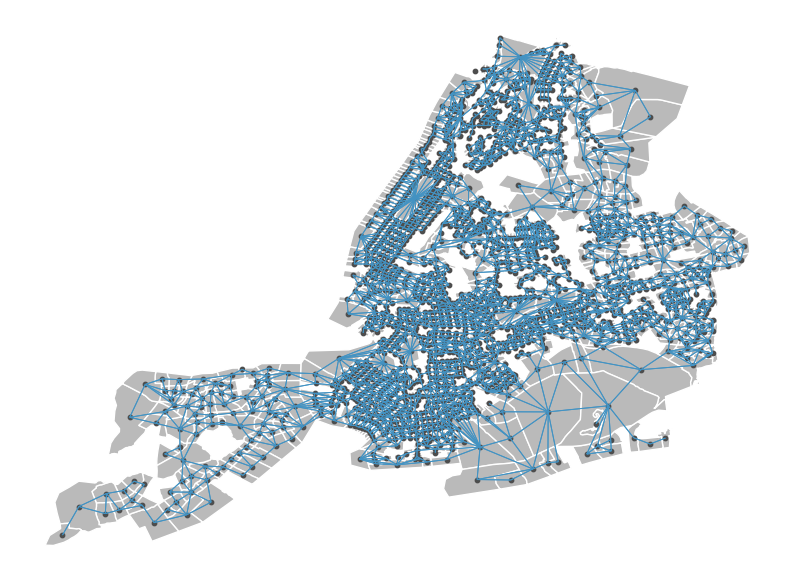

In [7]:
from splot.libpysal import plot_spatial_weights
import matplotlib.pyplot as plt

nyc_nbs = sa.weights.Rook(nyc_shp_subset['geometry'])
plot_spatial_weights(nyc_nbs, nyc_shp_subset)
plt.show()

In the following plot, the first panel shows the 2001 log population per census tract and the second panel shows the raw number of 2001 events.

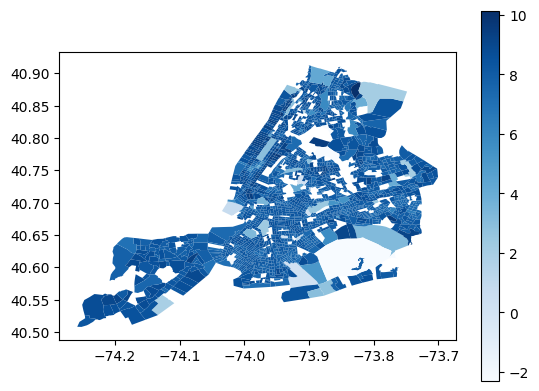

In [8]:
nyc_shp_subset.plot(column="log_pop_2001", legend=True, cmap="Blues")
plt.show()

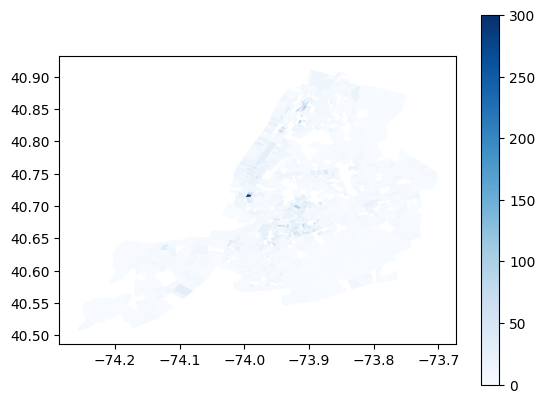

In [9]:
nyc_shp_subset.plot(column="events_2001", legend=True, cmap="Blues")
plt.show()

#### Baseline model: a simple Poisson GLM

In [10]:
N = len(nyc_shp_subset["events_2001"])
y = nyc_shp_subset["events_2001"]
E = nyc_shp_subset["pop_2001"]

# Set population > 0
E[E < 10] = 10

data = {"N": N, "y": y, "E": E}
pois_model = CmdStanModel(stan_file="stan/pois.stan")
pois_model_stanfit = pois_model.sample(data=data)

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_99884/3423646791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
13:50:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:50:52 - cmdstanpy - INFO - CmdStan done processing.


In [11]:
vars = [
    "beta0",
    "mu[1]",
    "mu[2]",
    "mu[3]",
    "mu[500]",
    "mu[1000]",
    "mu[1500]",
    "mu[1900]",
]

pois_model_summary = pois_model_stanfit.summary()
pois_model_summary.loc[vars]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
beta0,-6.12302,0.000222,0.008046,-6.13644,-6.12296,-6.11018,1309.20,106.293,1.00165
mu[1],10.54300,0.002345,0.084818,10.40210,10.54330,10.67890,1308.29,106.218,1.00165
mu[2],4.64463,0.001033,0.037366,4.58256,4.64474,4.70450,1308.31,106.220,1.00165
mu[3],7.13900,0.001588,0.057433,7.04361,7.13918,7.23103,1308.32,106.221,1.00165
mu[500],15.87590,0.003531,0.127720,15.66380,15.87630,16.08050,1308.34,106.222,1.00165
mu[1000],8.08590,0.001798,0.065050,7.97785,8.08610,8.19013,1308.33,106.221,1.00165
mu[1500],5.45124,0.001212,0.043855,5.37840,5.45138,5.52151,1308.32,106.221,1.00165
mu[1900],13.90320,0.003092,0.111851,13.71740,13.90350,14.08240,1308.28,106.218,1.00165


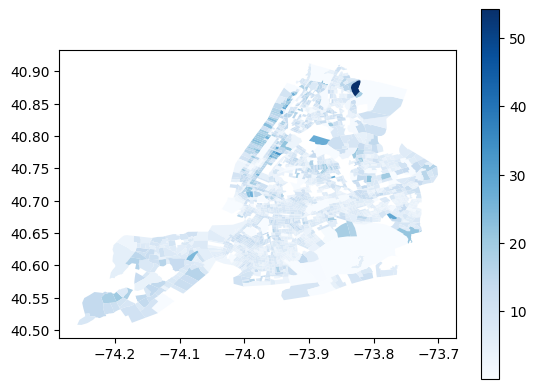

In [12]:
mu_index = pois_model_summary.index.str.contains("mu")
mu_mean = pois_model_summary.loc[mu_index, "Mean"].reset_index(drop=True)
nyc_shp_subset.assign(mu = mu_mean).plot(column="mu", legend=True, cmap="Blues")
plt.show()

#### Adding a vector of random effects (heterogeneous variation only)

In [13]:
pois_re_model = CmdStanModel(stan_file="stan/pois_re.stan")
pois_re_model_stanfit = pois_re_model.sample(data=data)

13:51:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:51:44 - cmdstanpy - INFO - CmdStan done processing.


In [14]:
vars = [
    "beta0",
    "mu[1]",
    "mu[2]",
    "mu[3]",
    "mu[500]",
    "mu[1000]",
    "mu[1500]",
    "mu[1900]",
    "theta[1]", 
    "theta[2]", "theta[3]", 
    "theta[500]", 
    "theta[1000]", 
    "theta[1500]", 
    "theta[1900]"
]

pois_re_model_summary = pois_re_model_stanfit.summary()
pois_re_model_summary.loc[vars]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
beta0,-6.589060,0.001020,0.031076,-6.640810,-6.588450,-6.538670,927.498,20.5745,1.001870
mu[1],18.293200,0.038835,4.119230,12.056400,18.026700,25.564200,11250.900,249.5760,0.999366
mu[2],0.963103,0.009882,0.760292,0.168765,0.760922,2.477420,5919.870,131.3190,0.999688
mu[3],3.303660,0.018052,1.690070,1.128100,3.006020,6.533830,8764.810,194.4280,0.999552
mu[500],29.134400,0.055586,5.474140,20.658100,28.814500,38.849300,9698.330,215.1360,0.999479
mu[1000],4.233940,0.021582,1.976570,1.615210,3.872290,7.949240,8387.510,186.0580,1.000200
mu[1500],1.628050,0.010591,1.017870,0.411859,1.404570,3.626790,9237.000,204.9020,0.999194
mu[1900],1.409430,0.011668,0.971775,0.321919,1.167580,3.283890,6936.150,153.8630,0.999757
theta[1],0.825674,0.002194,0.192567,0.502717,0.834099,1.128340,7700.430,170.8170,0.999710
theta[2],-1.166650,0.007321,0.668134,-2.379960,-1.117920,-0.135267,8327.840,184.7350,0.999332


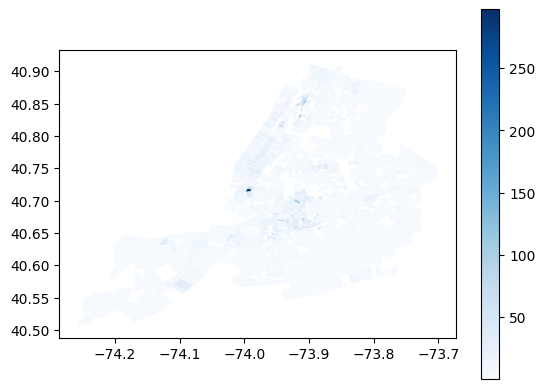

In [15]:
mu_index = pois_re_model_summary.index.str.contains("mu")
mu_mean = pois_re_model_summary.loc[mu_index, "Mean"].reset_index(drop=True)
nyc_shp_subset.assign(mu = mu_mean).plot(column="mu", legend=True, cmap="Blues")
plt.show()

#### Adding an ICAR component (spatial smoothing only)